In [1]:
!pip3 install box2d-py
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
from gym import wrappers
import torch as T 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

## Get Familiar with the State Space and Actions 

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)

[0]

In [3]:
# inspect action space and state space
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(-inf, inf, (8,), float32)


In [4]:
# Get state and action sizes
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

print('State size: {}, action size: {}'.format(num_states, num_actions))

State size: 8, action size: 4


## Random Agent 
This is based on the class notebook introducing the Cartpole toy problem. 

In [5]:
# Agent that takes random actions
max_episodes = 100

In [6]:
scores = []
actions = range(env.action_space.n)
for i in range(1, max_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = np.random.choice(actions)
        state, reward, done, info = env.step(action)
        score += reward
        if done:
            if i % 20 == 0:
                print('Episode {},  score: {}'.format(i, score))
            break
    
    scores.append(score)

Episode 20,  score: -195.43262783442657
Episode 40,  score: -263.76802578179445
Episode 60,  score: -383.4539026596413
Episode 80,  score: -275.5699497352973
Episode 100,  score: -121.44648947414903


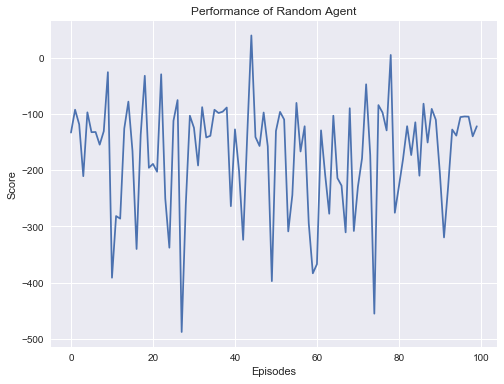

In [7]:
# Show random agent's performance
plt.figure(figsize=(8,6))
plt.plot(range(max_episodes), scores)
plt.title('Performance of Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()

In [8]:
# Average score
print('Average score of random agent over {} episodes: {:.2f}'.format(max_episodes, np.mean(scores)))

Average score of random agent over 100 episodes: -171.97


## Implementing Deep Q-learning 

In [9]:
# Use cuda if available else use cpu
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

## Hyperparameters 

In [10]:
# Hyperparameters: set these up as global variables
# so I can test tuning them frm here 
 
BUFFER_SIZE = 50000 # Replay memory size
BATCH_SIZE = 64     # Number of experiences to sample from memory
GAMMA = 0.99        # Discount factor
LR = 1e-4           # Q Network alpha learning rate
UPDATE_EVERY = 4    # How often to update Q network

In [11]:
MAX_EPISODES = 2000  # Max number of episodes to play
MAX_STEPS = 1000     # Max steps allowed in a single episode/play
ENV_SOLVED = 200     # Average Reward where an environment is considered solved
PRINT_EVERY = 100    # After this many episodes, print the progress 

# Epsilon Decay 

EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01       # Minimum epsilon 

## Action Value Network
This class implements the **function approximator** used in the agent. In this case, the function approximator is a ***neural network***. We are using a neural network for approximating the action-value function in a control problem. Neural networks can also be used as the function approximator for policy evaluation problems. When using a neural network to approximate a state-value function, the output layer only includes one unit. For an action-value function, the number of units in the output layer needs to match the number of actions. 


In [12]:
class DeepQNetwork(nn.Module):
    """
    LinearClassifier that derives from nn.Module
    the reason that we derive PyTorch classes from nn.Module
    is because that gives us access to parameters of deep neural network
    """
    def __init__(self, num_states, num_actions, seed):
        """
        takes number of states and number of actions as input
        use a seed for reproducibility: 
        https://pytorch.org/docs/stable/notes/randomness.html
        whenever we are deriving one class from another, 
        we want to use the super constructor 
        """
        super(DeepQNetwork, self).__init__()
        # declare layers of deep neural network 
        # we have three fully connected linear layers 
        # input layer, hidden layer, and output layer 
        # You can use torch.manual_seed() to seed the RNG for all devices (both CPU and CUDA):
        self.seed = T.manual_seed(seed)
        # torch.nn.Linear(in_features: int, out_features: int) 
        # we have num_states (which is 8 in this case) as the input 
        self.fc1 = nn.Linear(num_states, 256)
        self.fc2 = nn.Linear(256, 128)
        """
        we have n_actions as output for this layer 
        because we want to calculate estimate for Q which is a state, action pair
        Q is a state, value action function, 
        we want to get out the value of each action for that state 
        dimensionality must correspond to number of actions for have for our environment
        """
        self.fc3 = nn.Linear(128, num_actions) 
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device) 
    # PyTorch handles backpropagation algorithm for us,
    # but we need to define own forward propagation algorithm    
    def forward(self, state):
        """
        pass data through each linear layer and activate it 
        with the relu function 
        returns actions tensor with shape [4] 
        """
        layer1 = F.relu(self.fc1(state))
        layer2 = F.relu(self.fc2(layer1))
        actions = self.fc3(layer2)
        #print(actions.shape)
        return actions        

## The Agent's Memory
We need memory of:
+ States
+ Actions
+ Rewards
+ New States 
+ Dones (target is different when new state is terminal compared to not terminal) 

* Uniformly sample memories up to most recent so every memory has an equal probability of being sampled. 
* We shouldn't repeat memories. 

## Implemenation Tips:
* Can use dequeues or numpy arrays 
* We do need to return numpy arrays at the end anyway. 
* Have separate arrays for each thing we are storing so there isn't confusion later when we go to access the agent's memory. 
* We could also reurn PyTorch tensors. A downside of this is that if I decided I wanted to switch the project to TensorFlow or Keras, I would need to rewrite part of the agent's memory. 
These tips are from the Udemy Course Modern Reinforcement Learning: Deep Q Learning in PyTorch where Phil Tabor implements a Deep Q Learning Agent to play Pong. 
https://www.udemy.com/course/deep-q-learning-from-paper-to-code/learn

 We can use a more efficient approach for updating value functions.  The idea behind Dyna is to learn a model using sampled experience, obtain simulated experience from the model, and improve the value function using the simulated experience.

**Experience replay** is a simple method that can get some of the advantages of Dyna by saving a buffer of experience and using the data stored in the buffer as a model. This view of prior data as a model works because the data represents actual transitions from the underlying MDP. Furthermore, as a side note, this kind of model that is not learned and simply a collection of experience can be called non-parametric as it can be ever-growing as opposed to a parametric model where the transitions are learned to be represented with a fixed set of parameters or weights.

ReplayBuffer includes two main functions: append() and sample(). append() adds an experience transition to the buffer as an array that includes the state, action, reward, terminal flag (indicating termination of the episode), and next_state. sample() gets a batch of experiences from the buffer with size minibatch_size.

You will use the append() and sample() functions when implementing the agent.
These notes about **replay buffers** are based on the Coursera Course, "A Complete Reinforcement Learning System Capstone" by the University of Alberta. 
https://www.coursera.org/learn/complete-reinforcement-learning-system/lecture/ToRFI/meeting-with-niko-choosing-the-learning-algorithm

In [13]:
class ReplayBuffer():
    """"
    this generic replay buffer comes from Phil Tabor:
    https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/replay_memory.py
    to adapt this to my project, one of the biggest hangups was getting the numpy arrays
    to have the correct dimensions for when they are turned into PyTorch tensors later on
    one of my biggest challenges with PyTorch was choosing the correct datatype 
    so I appreciate the datatypes Tabor carefully chose for the NumPy arrays
    a Replay Buffer typically has two key functions: append and sample 
    """
    def __init__(self, buffer_size, input_shape, n_actions, seed):
        """
        constructor for the replay buffer takes 
        buffer_size, input shape which corresponds to state space dimensions,
        number of actions, and seed to that results are reproducible 
        """
        self.seed = random.seed(seed)
        self.mem_size = buffer_size
        """
        one of the design decisions that needed to be made
        was how to handle sampling for the episodes the agent 
        ran before filling up the replay buffer 
        the memory counter helps make that decision
        use memory counter with modulo on the size of the replay 
        buffer also helps overwrite old experiences with new experiences 
        """
        self.mem_counter = 0
        # the numpy arrays for state_memory and new_state memory
        # both have shape (64, 8)
        # 64 is the batch size, 8 is the size of the state space 
        self.state_memory = np.zeros((self.mem_size, input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                         dtype=np.float32)
        # later these numpy arrays will get turned into PyTorch tensors
        # it is critical that the batches returned have size (64, 1), note: 64 is the batch size
        # add a 1 dimension to the array here so that the batch dimension will ultimately be correct
        self.action_memory = np.zeros((self.mem_size, 1), dtype=np.int64)
        #self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory = np.zeros((self.mem_size, 1), dtype=np.float32)
        # led to trying to do subtraction with bool type 
        # changed terminal_memory array from type bool to int32 
        # due to how I handle my masking later on in the loss calculation 
        # self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        self.terminal_memory = np.zeros((self.mem_size, 1), dtype=np.int32)

    def add(self, state, action, reward, next_state, done):
        """
        can consider this the append feature 
        append() adds an experience transition to the buffer as an array 
        that includes the state, action, reward, 
        terminal flag (indicating termination of the episode), and next_state.
        """
        # modulo the memory counter with size of the buffer to find the index 
        # add state, action, reward, next_state, and done numeric variables
        # into the associated numpy array at that specific index 
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        # increment the memory counter every time the append function is used 
        self.mem_counter += 1

    def sample_buffer(self, batch_size):
        """
        sample() gets a batch of experiences from the buffer with size batch_size 
        """
        #max_mem = min(self.mem_counter, self.mem_size)
        max_mem = self.mem_size 
        # use random choice to randomly select the samples 
        batch = np.random.choice(max_mem, batch_size, replace=False)
        # create numpy arrays made up only of the randomly selected batch 
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]
        # return the numpy arrays with the batches 
        return states, actions, rewards, next_states, dones

## The Agent Class 
Innovation:
+ An **online network** that gets updated with **gradient descent** in addition to a **target network** that handles calculation of the target values. 
+ The **target network** only gets updated periodically with the weights of the **online network.** 
+ We also have a **replay buffer** that we use to sample the agent's history. 
+ Agent needs to be able to choose action, copy target network, decrement epsilon, learn and store memories 
+ Also need to load and save models (interface with the Deep Q Network) 


In [14]:
class DQNAgent:
    def __init__(self, num_states, num_actions, seed):
    #def __init__(self, lr, num_states, num_actions, seed):
        """
        Takes in number of states (int), number of actions(int), 
        Using a seed(int) for reproducibility. 
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.seed = random.seed(seed)
        # Initialize the separate q networks 
        # We have one Q network for the target and one for prediction 
        self.q_network = DeepQNetwork(num_states, num_actions, seed).to(device)
        self.fixed_network = DeepQNetwork(num_states, num_actions, seed).to(device)
        """
        Adam is a type of stochastic gradient descent with momentum
        it is an adaptive learning rate algorithm 
        for the Deep Q Learning algorithm, the paper does opt for RMSprop optimizer
        self.parameters() comes from nn.module and tells us what we want to optimize 
        """
        self.optimizer = optim.Adam(self.q_network.parameters())
        # initialize a ReplayBuffer instance 
        self.memory = ReplayBuffer(BUFFER_SIZE, num_states, num_actions, seed)
        # initialize a timestep counter, this is used to track when to update the network 
        self.timestep = 0

    def sample_memory(self):
        # this function is called to sample the replay buffer 
        # unpack the tuple of numpy arrays returned 
        state, action, reward, new_state, done = self.memory.sample_buffer(BATCH_SIZE)
        # convert the numpy arrays into PyTorch tensors 
        # the state and new_state tensors have shape [64, 8]
        # the rest of the arrays have tensor shape [64, 1]
        # this shape is why it was important to reshape the numpy arrays
        # in the ReplayBuffer class 
        states = T.tensor(state).to(self.q_network.device)
        actions = T.tensor(action).to(self.q_network.device)
        rewards = T.tensor(reward).to(self.q_network.device)
        new_states = T.tensor(new_state).to(self.q_network.device)
        dones = T.tensor(done).to(self.q_network.device)
      
        # return the PyTorch tensors 
        return (states, actions, rewards, new_states, dones)
    
    
        
    def learn(self, experiences):
        """
        Takes in experiences which is a tuple with numpy arrays
        which are the batches that the agent samples 
        """
        # we don't want to start learning until the replay buffer 
        # is filled up, for example it would be problematic 
        # to try to take a sample of size 64 from buffer with only 1 experience in it
        if dqn_agent.memory.mem_counter < BATCH_SIZE:
          return 
        """
        when training a neural network, models are able to increase accuracy 
        through gradient descent. Gradient descent is the process of minimizing loss
        by tweaking the weights and biases in model. 
        This is a good best practice before doing backpropagation because 
        PyTorch accumulates gradients on subsequent backward passes.
        See Stack overflow post (Why do we need to call zero_grad)
        TODO: look the placement of where zero_grad should occur 
        """   

        # break apart tuple experiences into these tensors 
        states, actions, rewards, next_states, dones = experiences
        
        # get the action with the max Q-value 
        # I really struggled with getting the torch tensor dimensions correct for this section
        # utilized this resource: https://www.datahubbs.com/deep-q-learning-101/
        # the PyTorch max function returns a tuple with the maximum value and index of the maximum value
        # use [0] to just get the max value for each row 
        # call detach to make sure that these values don't update the target network 
        # when we call loss.backward() and optimizer.step() 
        q_vals_next = T.max(self.fixed_network(next_states), dim=-1)[0].detach()
        # the q_vals_next tensor has shape [64]
        # we need to get the tensor to have shape [64, 1]
        # use unsqueeze[1] to add that extra dimension 
        max_action_vals = q_vals_next.unsqueeze(1)
        # If done just use reward, else update Q_target with discounted action values
        #  The qvals_next are set to 0 at terminal states because there are no future rewards to discount.
        # Then we combine all of these together with the reward and the discount factor to get the q_target
        q_target = rewards + (GAMMA * max_action_vals * (1 - dones))
        # To update the network, we need to get the Q-values for the actions that we actually took, 
        # use PyTorch’s gather() function to subset Q-values appropriately.
        q_expected = T.gather(self.q_network(states), 1, actions)
        
        
        # Calculate loss
        # for Deep Learning, we want to use something 
        # like nn.MSELoss()
        loss = F.mse_loss(q_expected, q_target)
        """
        when training a neural network, models are able to increase accuracy 
        through gradient descent. Gradient descent is the process of minimizing loss
        by tweaking the weights and biases in model. 
        This is a good best practice before doing backpropagation because 
        PyTorch accumulates gradients on subsequent backward passes.
        See Stack overflow post (Why do we need to call zero_grad)
        https://stackoverflow.com/questions/44732217/why-do-we-need-to-explicitly-call-zero-grad/44732271
        """
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
        # Update fixed weights
        self.update_fixed_network(self.q_network, self.fixed_network)
        
        
        
    def update_fixed_network(self, q_network, fixed_network):
        """
        update fixed network by copying weights from Q network 
        zipping together source and target parameters will make 
        it possible to iterate over and copy the weights from the q network
        to the fixed network 
        """
        
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            # copy weights from q network to fixed network 
            target_parameters.data.copy_(source_parameters.data)
        
        
    def act(self, state, epsilon=0.0):
        """
        Choose the action using an Epsilon Greedy Action Selection Strategy
        takes environment state as input 
        random.random() returns a number between 0.0 and 1.0 
        https://stackoverflow.com/questions/33359740/random-number-between-0-and-1-in-python
        if greater than epsilon, take greedy action 
        returns integer corresponding to action 
        """
        if random.random() > epsilon:
          """
          make sure the state is Pytorch tensor 
          that is sent to actual kuda device 
          Pytorch is quite particular about datatypes of tensors passed in 
          device is a property of the LinearDeepQNetwork
           set dtype of float to be extra cautious about making sure everything matches up
          """
          state = T.tensor(state, dtype=T.float).to(device)
          """  
          looked at this post about eval vs train mode
          https://jamesmccaffrey.wordpress.com/2019/01/23/pytorch-train-vs-eval-mode/
          if you use batch normalization or dropout,
          you must set model to model evaluation mode when computing model output values
          then you set back to default training mode when done 
          neural network doesn't use batch normalization or droput out,
          but set this up to somewhat future proof it
          """
          self.q_network.eval()
          with T.no_grad():
              actions = self.q_network.forward(state)
          self.q_network.train()
          """
          take argmax of tensor actions 
          need to dereference it with a .item function
          this is a nuance of the Pytorch framework,
          when you feed forward state through the Q network,
          you don't get back a numpy array, you get back a tensor
          a tensor won't serve as appropriae input to OpenAI Gym's environment
          the .item function gets the numpy array out of it 
          """
          action = T.argmax(actions).item() 
        # otherwise choose a random action 
        else: 
          action = np.random.choice(self.num_actions)
        return action 

    def checkpoint(self, filename):
        T.save(self.q_network.state_dict(), filename)

## Main Game Loop 
Follows that standard OpenAI Gym form like the class Cartpole notebook. 

In [15]:
# instantiate a DQNAgent 
dqn_agent = DQNAgent(num_states, num_actions, seed=0)

In [ ]:
# keep track of how long it takes to get to max number of episods 
start = time()
# initialize list to keep track of scores 
scores = []
# Maintain a list of last 100 scores
# An environment is considered to be solved
# or not based on average reward for past 100 episodes
scores_window = deque(maxlen=100)
epsilon = EPS_START
#env = wrappers.Monitor(env, "/Users/cailyncraven/Documents/CSPB_3202/dqn-video7", video_callable=lambda episode_id: True, force=True)
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    # adding this in 
    timestep = 0 
    for step in range(MAX_STEPS):
        action = dqn_agent.act(state, epsilon)
        next_state, reward, done, info = env.step(action)
        dqn_agent.memory.add(state, action, reward, next_state, done)
        timestep += 1 
        if timestep % UPDATE_EVERY == 0:
            sampled_experiences = dqn_agent.sample_memory()
            dqn_agent.learn(sampled_experiences)     
        state = next_state        
        score += reward        
        if done:
            break
            
        epsilon = max(epsilon * EPS_DECAY, EPS_MIN)
        #if episode > MAX_EPISODES - 6:
        #    env = wrappers.Monitor(env, "/Users/cailyncraven/Documents/CSPB_3202/dqn-video10", video_callable=lambda episode_id: True, force=True)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Episode {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rSolved game in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('solved_200.pth')
            break
            
    scores_window.append(score)
    scores.append(score)
    
end = time()    
print('Took {} seconds'.format(end - start))

Solved game in 912 episodes, average score: 252.01

In [ ]:
for i in range(5):
    score = 0
    state = env.reset()
    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print('episode: {} scored {}'.format(i, score))

In [ ]:
dqn_agent.checkpoint('solved_200.pth')

## Plot 

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# Add a trend line 
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of Episodes')
plt.ylabel('Score')
plt.show()

In [ ]:
env.close()

## Metaparameter Choices
+ Function Approximator 
+ Optimizer Choices for updating action values
+ How to do exploration 

## For Function Approximator:
+ It would make sense to start simple with something like Tile Coder: Here we have 8 dimensions. If we wanted to use 10 tiles per dimension, that would be 10^8. We could easily end up with 100 million features. 
+ Because of this it makes sense to use a **neural network** instead. This should be sufficiently powerful for the LunarLander problem. You get to choose how many neurons there will be. Adding more neurons to a hidden layer gives more representational power, but the more nodes you add, the more parameters there are to learn. Neural Networks can be viewed as constructing featurs. Neural networks are non-linear functions of state.  

## Choose Activation Function 
We could use a sigmoidal function like **tanh**. These have some issues with sauration. There can be the **vanishing gradient issue.** A common popular choice is **ReLUs**. 

## How are we going to train the network?
Using vanilla **stochastic gradient descent**, will likely be too slow for this project so what other options do we have? 
+ We could use **adagrad**. The downside of this is that it decays values down to zero. This can be problematic for non-stationary learning. 
+ **RMSProp** uses information about the curvature of the plots to improve the descent step. 
+ We do also want to incorporate **momentum** to speed up learning. **Adam** is a good choice because it combines the curvature information from RMSProp and momentum. 
+ What **exploration strategy** will we use? 

+ **Optimistic Initial Values**: this would be a good choice if we were using a linear function approximator with non-negative features. We are using a neural network so it is difficult to maintain optimistic values, and they are unlikely to be effective. 
+ We can also consider **Epsilon Greedy.** This is easy to straightforward to implement. The downside is that its exploration ignores whatever information the action values may have. It is equally likely to explore an action with a really negative value as an action with a moderately negative value. 
+ **Softmax**: a good choice because the probability of selecting an action is proportional to the value of the action. This way we are less likely to explore actions that we think are really bad. There are a few things to consider when using sofmax on action values. 
  + use **tau** as a temperature parameter. If tau is large, then the agent is more stochastic. For a very large tau, the agent behaves almost like a uniform random policy. For a very small tau, the agent mostly selects the greedy action. 

To brainstorm some of the key choices for an agent, we can reason through what choices would make the most sense. Other choices like specific step sizes in the optimizer and exploration parameters like the temperature can be less obvious to simply select. 